
# Netflix: Unsupervised EDA, Clustering & Content-Based Recommendations

**Unsupervised problems**
1) **Catalog Structuring via Clustering** (no labels): discover thematic groupings from text + genres and compare to metadata (type, country).
2) **Content-Based Recommendations** (unsupervised retrieval): return similar titles from vector representations.

**Representations**
- Text **TF-IDF** (1–2 grams)
- **GloVe 100d** (avg word embeddings) https://nlp.stanford.edu/data/wordvecs/glove.2024.wikigiga.100d.zip
- Genres: **MultiLabelBinarizer** + **genre TF-IDF**

**Models**
- **KMeans** with k-sweep (silhouette/Calinski-Harabasz)
- **HDBSCAN** (density-based clusters + noise)
- **NMF** topics on TF-IDF
- **SVD** for 2d map

**Non-replication pledge**
- Multiple unsupervised models + hyperparam sweeps
- External validation (NMI/ARI vs. type / genre)
- Two independent encodings in recommender + metric comparisons (cosine, Jaccard, hybrid)

**Dataset**: `netflix_titles.csv` (https://www.kaggle.com/datasets/shivamb/netflix-shows/data)


In [1]:
import pandas as pd, numpy as np, re
from collections import Counter
from itertools import combinations
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

import os, tempfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import NMF
import hdbscan




**Data Preprocessing & Duration Estimation**

I normalize the schema, parse dates, split multi-valued fields, and create a transparent duration proxy. Netflix TV rows store duration as "N Season(s)" - I derive seasons and estimate minutes per season using macro-genre heuristics.

**Duration Processing**: I split duration into minutes for movies and seasons for TV shows to create consistent numeric values for analysis. For TV shows, I estimate total minutes using industry norms: seasons × (typical episodes/season) × (typical minutes/episode) based on macro-genre patterns (e.g., comedies ~25 min, dramas ~55 min, anime ~24 min).


In [2]:
CSV_PATH = "netflix_titles.csv" 
df = pd.read_csv(CSV_PATH)
df.columns = df.columns.str.strip().str.lower()
df = df.drop_duplicates(subset=["show_id"]).reset_index(drop=True)

# Dates & numeric
df["date_added"]   = pd.to_datetime(df["date_added"], errors="coerce")
df["release_year"] = pd.to_numeric(df["release_year"], errors="coerce")

In [3]:
def normalize_genres(genre_list):
    """Single function for genre normalization - converts to underscore format"""
    if not genre_list:
        return ""
    return " ".join([g.replace("&","and").replace(" ","_").lower() for g in genre_list])

def split_list(s: str):
    if pd.isna(s): return []
    return [x.strip() for x in str(s).split(",") if x and x.strip()]

for col in ["listed_in","country","cast","director"]:
    df[col+"_list"] = df[col].apply(split_list)

# Parse seasons for TV and minutes for Movies (raw)
def parse_duration_minutes_or_seasons(s):
    if pd.isna(s): return (np.nan, np.nan)
    s = str(s).lower().strip()
    if "min" in s:
        # movie minutes, no seasons
        m = re.findall(r"(\d+)\s*min", s)
        return (int(m[0]) if m else np.nan, np.nan)
    if "season" in s:
        m = re.findall(r"(\d+)", s)
        return (np.nan, int(m[0]) if m else 1)
    return (np.nan, np.nan)

mins, seas = zip(*df["duration"].map(parse_duration_minutes_or_seasons))
df["duration_minutes_raw"] = mins
df["seasons"] = seas

# Canonical text: title + description + normalized genres (underscored)
df["text"] = (
    df["title"].fillna("") + " " +
    df["description"].fillna("") + " " +
    df["listed_in_list"].apply(normalize_genres).fillna("")
).str.lower()

In [4]:
df.head(3)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,listed_in_list,country_list,cast_list,director_list,duration_minutes_raw,seasons,text
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",[Documentaries],[United States],[],[Kirsten Johnson],90.0,NaN,dick johnson is dead as her father nears the e...
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...","[International TV Shows, TV Dramas, TV Mysteries]",[South Africa],"[Ama Qamata, Khosi Ngema, Gail Mabalane, Thaba...",[],NaN,2.0,"blood & water after crossing paths at a party,..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,"[Crime TV Shows, International TV Shows, TV Ac...",[],"[Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nab...",[Julien Leclercq],NaN,1.0,ganglands to protect his family from a powerfu...


In [5]:
df.describe()

,date_added,release_year,duration_minutes_raw,seasons
count,8709,8807.000000,6128.000000,2676.000000
mean,2019-05-23 01:45:29.452290816,2014.180198,99.577187,1.764948
min,2008-01-01 00:00:00,1925.000000,3.000000,1.000000
25%,2018-04-20 00:00:00,2013.000000,87.000000,1.000000
50%,2019-07-12 00:00:00,2017.000000,98.000000,1.000000
75%,2020-08-26 00:00:00,2019.000000,114.000000,2.000000
max,2021-09-25 00:00:00,2021.000000,312.000000,17.000000
std,NaN,8.819312,28.290593,1.582752


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   show_id               8807 non-null   object        
 1   type                  8807 non-null   object        
 2   title                 8807 non-null   object        
 3   director              6173 non-null   object        
 4   cast                  7982 non-null   object        
 5   country               7976 non-null   object        
 6   date_added            8709 non-null   datetime64[ns]
 7   release_year          8807 non-null   int64         
 8   rating                8803 non-null   object        
 9   duration              8804 non-null   object        
 10  listed_in             8807 non-null   object        
 11  description           8807 non-null   object        
 12  listed_in_list        8807 non-null   object        
 13  country_list      

I split duration into minutes for movies and season counts for TV because the raw field mixes two incompatible units (“120 min” vs “2 Seasons”), which breaks downstream analysis and similarity math. Parsing them separately gives a clean numeric movie runtime (duration_minutes_raw) and a TV seasons column I can later convert to minutes. To make that conversion defensible, I first do genre engineering (split and normalize listed_in, then map to macro-genres) so each TV title inherits a reasonable episodes-per-season × minutes-per-episode profile based on industry norms (e.g., comedies ~25 min, dramas ~55 min, anime ~24 min, season sizes ~8–10 or ~12–13). This lets us auto-fill a comparable duration_min for TV entries—transparent (I keep a duration_proxy_source flag), consistent across the catalog, and far more useful for EDA, clustering, and content-based recommendations than leaving TV runtimes as missing or mixing minutes with season counts.

In [7]:
df.head(2)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,listed_in_list,country_list,cast_list,director_list,duration_minutes_raw,seasons,text
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",[Documentaries],[United States],[],[Kirsten Johnson],90.0,NaN,dick johnson is dead as her father nears the e...
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...","[International TV Shows, TV Dramas, TV Mysteries]",[South Africa],"[Ama Qamata, Khosi Ngema, Gail Mabalane, Thaba...",[],NaN,2.0,"blood & water after crossing paths at a party,..."


I needed genre engineering because listed_in is a messy, free-text, multi-label field (e.g., “TV Dramas, International TV Shows”) that’s unusable as-is for modeling. By splitting and normalizing it, then turning it into structured features—(1) a MultiLabelBinarizer multi-hot matrix for exact membership, (2) macro-genre buckets to reduce noise and improve interpretability, and (3) a genre TF-IDF vector to weight distinctive tags, I unlock several things: clean filters, Jaccard/cosine similarities for the recommender, clearer clustering signals, and consistent runtime estimation for TV (episodes × minutes guided by macro-genre). In short, genre engineering converts vague labels into robust, quantitative features that power EDA, unsupervised models, and the duration proxy—while staying transparent and explainable.

2) Genre Engineering
I transform `listed_in` into structured features:
- **MultiLabelBinarizer**: fine-grained multi-hot matrix (`G_multi`)
- **Macro-genre mapping**: readable buckets (`G_macro`) for EDA and modeling
- **Co-occurrence communities**: data-driven meta-genres


In [8]:

# 2.1 MultiLabelBinarizer (fine-grained)
mlb = MultiLabelBinarizer()
G_multi = pd.DataFrame(
    mlb.fit_transform(df["listed_in_list"]),
    columns=mlb.classes_,
    index=df.index
)

# 2.2 Macro-genre mapping (regex buckets)
import re as _re
MACRO_MAP = {
    r"stand[- ]?up|comedy": "Comedy",
    r"drama": "Drama",
    r"crime|mystery|thriller": "Crime/Thriller",
    r"action|adventure": "Action/Adventure",
    r"sci[- ]?fi|fantasy": "Sci-Fi & Fantasy",
    r"horror": "Horror",
    r"romance|romantic": "Romance",
    r"kids|children|family": "Kids & Family",
    r"documentar": "Documentary",
    r"reality|talk show|variety": "Reality/Talk",
    r"anime": "Anime",
    r"music|musical|concert": "Music",
    r"sports": "Sports",
    r"faith|spiritual": "Faith/Spiritual",
    r"classics": "Classics",
    r"international|foreign": "International",
    r"lgbt": "LGBTQ+"
}
def map_macro(genres):
    out = set()
    for g in genres:
        g_low = g.lower()
        matched = False
        for pat, macro in MACRO_MAP.items():
            if _re.search(pat, g_low):
                out.add(macro); matched = True
        if not matched and g_low.startswith("tv "):
            g2 = g_low[3:]
            for pat, macro in MACRO_MAP.items():
                if _re.search(pat, g2):
                    out.add(macro); matched = True
    return sorted(out) if out else ["Other"]

df["macro_genres"] = df["listed_in_list"].apply(map_macro)
mlb_macro = MultiLabelBinarizer()
G_macro = pd.DataFrame(
    mlb_macro.fit_transform(df["macro_genres"]),
    columns=mlb_macro.classes_,
    index=df.index
)

# 2.3 Frequency pruning (optional compact one-hot)
topN = 40
top_genres = G_multi.sum().sort_values(ascending=False).head(topN).index
G_top = G_multi[top_genres].copy()
G_top["Other"] = (G_multi.drop(columns=top_genres).sum(axis=1) > 0).astype(int)



In [9]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,listed_in_list,country_list,cast_list,director_list,duration_minutes_raw,seasons,text,macro_genres
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",[Documentaries],[United States],[],[Kirsten Johnson],90.0,NaN,dick johnson is dead as her father nears the e...,[Documentary]
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...","[International TV Shows, TV Dramas, TV Mysteries]",[South Africa],"[Ama Qamata, Khosi Ngema, Gail Mabalane, Thaba...",[],NaN,2.0,"blood & water after crossing paths at a party,...","[Drama, International]"
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,"[Crime TV Shows, International TV Shows, TV Ac...",[],"[Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nab...",[Julien Leclercq],NaN,1.0,ganglands to protect his family from a powerfu...,"[Action/Adventure, Crime/Thriller, International]"
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,2021-09-24,2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...","[Docuseries, Reality TV]",[],[],[],NaN,1.0,"jailbirds new orleans feuds, flirtations and t...",[Reality/Talk]
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,"[International TV Shows, Romantic TV Shows, TV...",[India],"[Mayur More, Jitendra Kumar, Ranjan Raj, Alam ...",[],NaN,2.0,kota factory in a city of coaching centers kno...,"[International, Romance]"



2.5 Estimating TV Minutes per Season via Macro-Genres
**Motivation:** The Netflix CSV encodes TV as “N season(s)” without minutes.  
I derive **duration_min** for TV as:
\[
\text{seasons} \times \text{(typical eps/season)} \times \text{(typical minutes/episode)}
\]

**Heuristics (industry norms)**  (a quick google search + intuition, so really lacks scientific rigor, best I could do with a time limit)
- Streaming season sizes often cluster around **6–10 episodes**; many shows land near **8–10**.  
- **Comedies**: ~**22–30** minutes per episode; **Dramas**: ~**50–60** for streaming (vs. ~42–44 on broadcast).  
- **Anime**: typically **1 cour ≈ 12–13 episodes**, **~24 min** per ep.  
- Prestige/sci-fi finales can be **feature-length** (e.g., *Stranger Things* S4/S5).  

I set conservative midpoints by macro-genre and keep it **transparent** via a `duration_proxy_source` flag.

*(See References cell for sources.)*

In [10]:
# Ranges chosen to match sources in the References cell (streaming norms).
GENRE_EPS_MIN = {
    "Comedy":            (9.0, 27.5),
    "Drama":             (9.0, 55.0),
    "Crime/Thriller":    (7.0, 55.0),
    "Sci-Fi & Fantasy":  (9.0, 60.0),  
    "Documentary":       (8.0, 50.0),  
    "Reality/Talk":      (12.0, 45.0),
    "Kids & Family":     (13.0, 22.0),
    "Anime":             (12.5, 24.0),
    "Action/Adventure":  (9.0, 55.0),
    "Horror":            (8.0, 55.0),
    "Romance":           (8.0, 45.0),
    "Music":             (8.0, 45.0),
    "Sports":            (8.0, 45.0),
    "Faith/Spiritual":   (8.0, 45.0),
    "Classics":          (8.0, 50.0),
    "International":     (8.0, 50.0),
    "LGBTQ+":            (8.0, 50.0),
    "Other":             (9.0, 50.0),
}

def estimate_tv_minutes(row):
    """Estimate total minutes for TV rows using macro-genre midpoints × season count."""
    if row["type"] != "TV Show":
        return np.nan
    seasons = row.get("seasons", np.nan)
    if pd.isna(seasons) or seasons <= 0:
        seasons = 1
    macros = row.get("macro_genres", ["Other"])
    macro = macros[0] if len(macros) else "Other"
    eps, mins = GENRE_EPS_MIN.get(macro, GENRE_EPS_MIN["Other"])
    return seasons * eps * mins

df["duration_proxy_source"] = np.where(df["type"]=="Movie", "movie_minutes_raw", "macro_genre_estimate")
df["duration_min"] = np.where(
    df["type"]=="Movie",
    df["duration_minutes_raw"],
    df.apply(estimate_tv_minutes, axis=1)
)


In [11]:
pd.set_option('display.max_columns', None)
df.head(2)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,listed_in_list,country_list,cast_list,director_list,duration_minutes_raw,seasons,text,macro_genres,duration_proxy_source,duration_min
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",[Documentaries],[United States],[],[Kirsten Johnson],90.0,NaN,dick johnson is dead as her father nears the e...,[Documentary],movie_minutes_raw,90.0
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...","[International TV Shows, TV Dramas, TV Mysteries]",[South Africa],"[Ama Qamata, Khosi Ngema, Gail Mabalane, Thaba...",[],NaN,2.0,"blood & water after crossing paths at a party,...","[Drama, International]",macro_genre_estimate,990.0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   show_id                8807 non-null   object        
 1   type                   8807 non-null   object        
 2   title                  8807 non-null   object        
 3   director               6173 non-null   object        
 4   cast                   7982 non-null   object        
 5   country                7976 non-null   object        
 6   date_added             8709 non-null   datetime64[ns]
 7   release_year           8807 non-null   int64         
 8   rating                 8803 non-null   object        
 9   duration               8804 non-null   object        
 10  listed_in              8807 non-null   object        
 11  description            8807 non-null   object        
 12  listed_in_list         8807 non-null   object        
 13  cou

**Data Cleaning & Final Preparation**

Let's clean up NAs and datatypes:
1. Fix duration_min that could be NaN for movies using duration_raw, else impute median
2. Fill missing categories with 'Unknown'
3. Fix lists of country, cast, director, genre
4. Fix datatypes for numbers, categories, texts

In [13]:

def _backfill_duration_min(df):
    """Minimal data quality fixes for duration_min edge cases"""
    # Movies: use raw minutes if available, else median
    m_mask = (df["type"]=="Movie") & (df["duration_min"].isna())
    df.loc[m_mask, "duration_min"] = df.loc[m_mask, "duration_minutes_raw"]
    
    m_mask2 = (df["type"]=="Movie") & (df["duration_min"].isna())
    if m_mask2.any():
        med_movie = df.loc[df["type"]=="Movie","duration_minutes_raw"].median()
        df.loc[m_mask2, "duration_min"] = med_movie

    # TV: recompute if missing
    tv_mask = (df["type"]=="TV Show") & (df["duration_min"].isna())
    if tv_mask.any():
        df.loc[tv_mask, "duration_min"] = df.loc[tv_mask].apply(estimate_tv_minutes, axis=1)

    return df

# Rating: fill missing with "Unknown" then make categorical
df["rating"] = df["rating"].fillna("Unknown")

# Country/Cast/Director lists: ensure lists (no NaN)
for col in ["country_list","cast_list","director_list","listed_in_list","macro_genres"]:
    df[col] = df[col].apply(lambda x: x if isinstance(x, list) else [])


df.loc[df["type"]=="Movie", "seasons"] = 0
df.loc[df["type"]=="TV Show", "seasons"] = df.loc[df["type"]=="TV Show", "seasons"].fillna(1)
df["seasons"] = df["seasons"].astype("Int16")

# Backfill duration_min edge-cases
df = _backfill_duration_min(df)

df["type"] = df["type"].astype("category")
df["rating"] = df["rating"].astype("category")
df["release_year"] = df["release_year"].astype("Int16")   # compact nullable int
# Durations as float32 to save memory
df["duration_minutes_raw"] = df["duration_minutes_raw"].astype("float32")
df["duration_min"] = df["duration_min"].astype("float32")


# Keep the modeled/clean columns; drop raw text columns I replaced with list/processed forms.
cols_keep = [
    "show_id","type","title","date_added","release_year","rating",
    "duration_min","duration_proxy_source","seasons",
    "listed_in_list","macro_genres","country_list","cast_list","director_list",
    "text"
]
df_clean = df[cols_keep].copy()

# had to drop some rows due to NAN values not simply fixable
df_clean.dropna(inplace=True)

print(df_clean.isna().sum().sort_values(ascending=False))
print()
print(df_clean.info())


show_id                  0
type                     0
title                    0
date_added               0
release_year             0
rating                   0
duration_min             0
duration_proxy_source    0
seasons                  0
listed_in_list           0
macro_genres             0
country_list             0
cast_list                0
director_list            0
text                     0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
Index: 8709 entries, 0 to 8806
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   show_id                8709 non-null   object        
 1   type                   8709 non-null   category      
 2   title                  8709 non-null   object        
 3   date_added             8709 non-null   datetime64[ns]
 4   release_year           8709 non-null   Int16         
 5   rating                 8709 non-null   category      
 6   du

In [14]:
df_clean.head(2)

,show_id,type,title,date_added,release_year,rating,duration_min,duration_proxy_source,seasons,listed_in_list,macro_genres,country_list,cast_list,director_list,text
0,s1,Movie,Dick Johnson Is Dead,2021-09-25,2020,PG-13,90.0,movie_minutes_raw,0,[Documentaries],[Documentary],[United States],[],[Kirsten Johnson],dick johnson is dead as her father nears the e...
1,s2,TV Show,Blood & Water,2021-09-24,2021,TV-MA,990.0,macro_genre_estimate,2,"[International TV Shows, TV Dramas, TV Mysteries]","[Drama, International]",[South Africa],"[Ama Qamata, Khosi Ngema, Gail Mabalane, Thaba...",[],"blood & water after crossing paths at a party,..."


**3. EDA: Distributions, Associations, and Co-occurrence**

Data looks better and cleaner. Let's inspect dataset shape and justify modeling decisions with visualizations.


In [15]:
df = df_clean.copy()
df = df.reset_index(drop=True)

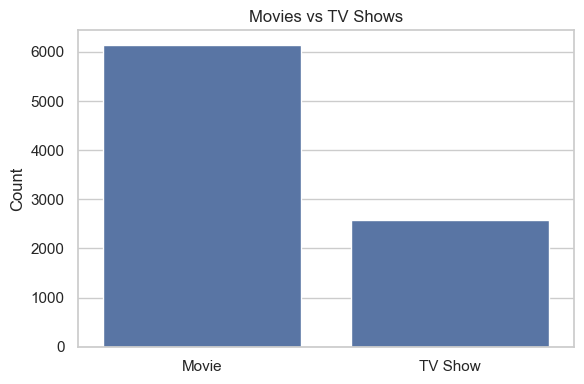

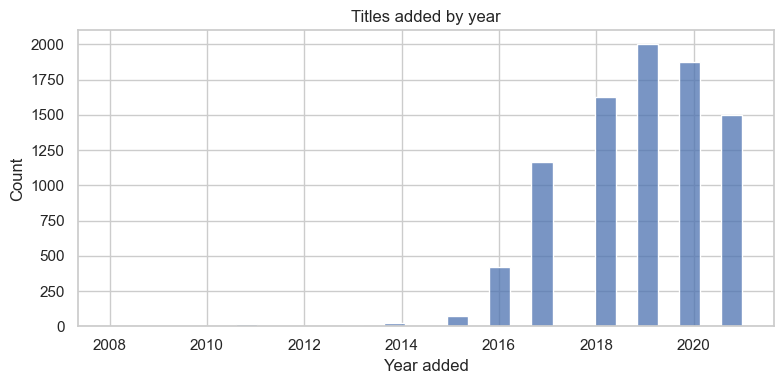

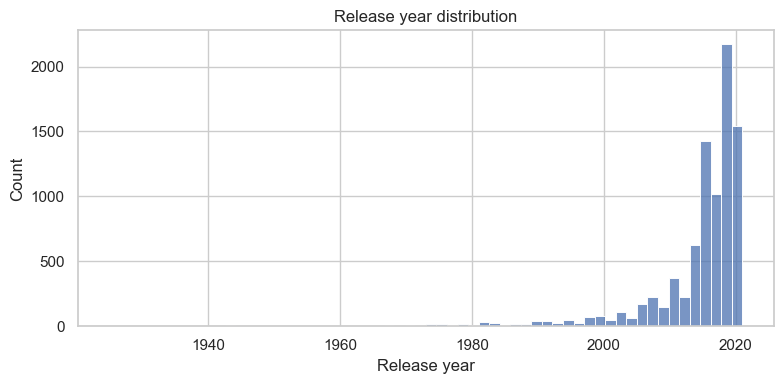

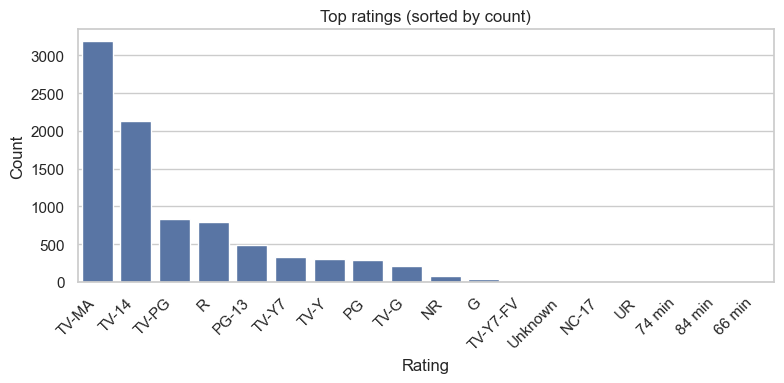

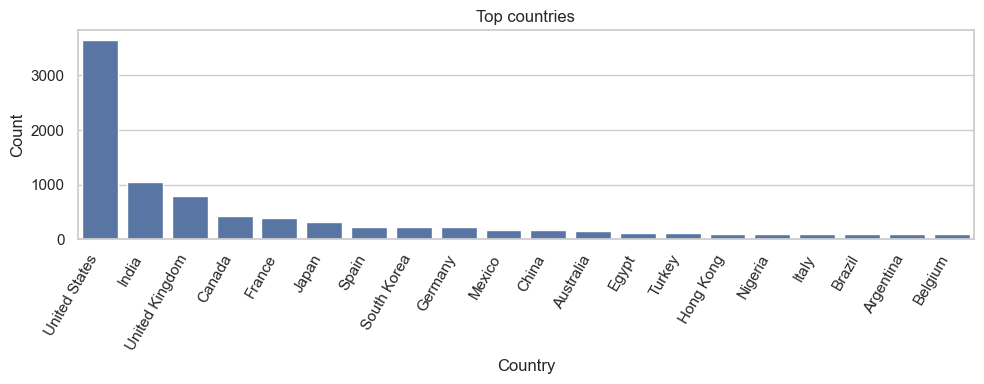

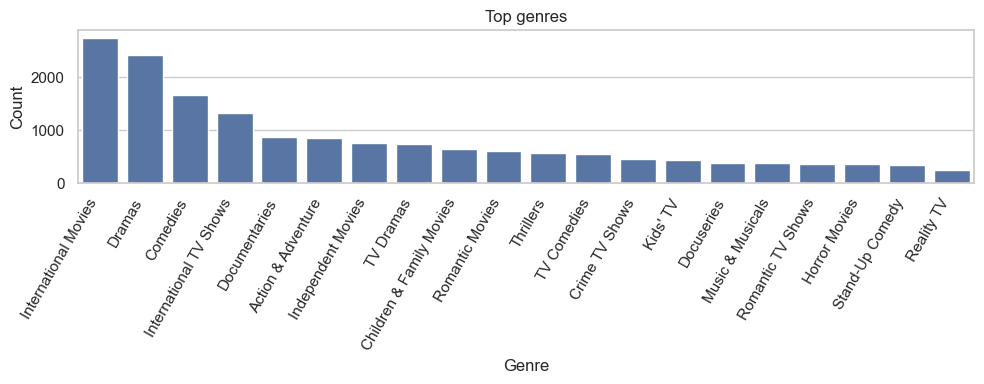

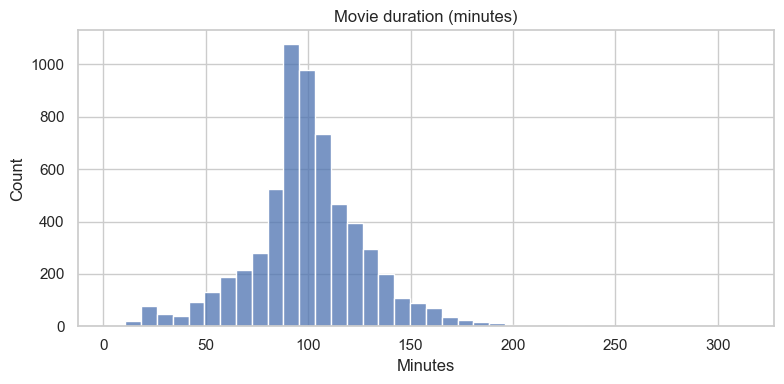

In [16]:
# 1) Movies vs TV Shows
plt.figure(figsize=(6,4))
ax = sns.countplot(data=df, x="type", order=df["type"].value_counts().index)
ax.set_title("Movies vs TV Shows")
ax.set_xlabel("")
ax.set_ylabel("Count")
plt.tight_layout()

# 2) Titles added by year (date_added)
df_year = df.assign(year_added=df["date_added"].dt.year)
plt.figure(figsize=(8,4))
ax = sns.histplot(df_year["year_added"].dropna(), bins=30, kde=False)
ax.set_title("Titles added by year")
ax.set_xlabel("Year added")
ax.set_ylabel("Count")
plt.tight_layout()

# 3) Release year distribution
plt.figure(figsize=(8,4))
ax = sns.histplot(df["release_year"].dropna(), bins=60, kde=False)
ax.set_title("Release year distribution")
ax.set_xlabel("Release year")
ax.set_ylabel("Count")
plt.tight_layout()

# 4) Top ratings
# counts sorted by frequency
ratings = (
    df["rating"].fillna("Unknown")
      .value_counts()
      .rename_axis("rating")
      .reset_index(name="count")
      .sort_values("count", ascending=False)
)

# lock the x order to the sorted order
order = ratings["rating"].tolist()

plt.figure(figsize=(8,4))
ax = sns.barplot(data=ratings, x="rating", y="count", order=order, errorbar=None)
ax.set_title("Top ratings (sorted by count)")
ax.set_xlabel("Rating"); ax.set_ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout(); plt.show()

# 5) Top countries
countries = df.explode("country_list")["country_list"].dropna()
top_countries = (
    countries.value_counts()
             .head(20)
             .rename_axis("country")
             .reset_index(name="count")
)
plt.figure(figsize=(10,4))
ax = sns.barplot(data=top_countries, x="country", y="count")
ax.set_title("Top countries")
ax.set_xlabel("Country")
ax.set_ylabel("Count")
plt.xticks(rotation=60, ha="right")
plt.tight_layout()

# 6) Top genres
genres_flat = df.explode("listed_in_list")["listed_in_list"].dropna()
top_genres = (
    genres_flat.value_counts()
               .head(20)
               .rename_axis("genre")
               .reset_index(name="count")
)
plt.figure(figsize=(10,4))
ax = sns.barplot(data=top_genres, x="genre", y="count")
ax.set_title("Top genres")
ax.set_xlabel("Genre")
ax.set_ylabel("Count")
plt.xticks(rotation=60, ha="right")
plt.tight_layout()

# 7) Movie duration histogram
plt.figure(figsize=(8,4))
movie_durations = df.loc[df["type"]=="Movie", "duration_min"].dropna()
ax = sns.histplot(movie_durations, bins=40, kde=False)
ax.set_title("Movie duration (minutes)")
ax.set_xlabel("Minutes")
ax.set_ylabel("Count")
plt.tight_layout()


### Correlations & Co-occurrence
- **Numeric**: `duration_min` vs `release_year` (weak expected).
- **Categorical associations**: `type` vs `rating` or top genre (qualitative).
- **Genres**: visualize co-occurrence heatmap (qualitative correlations).

              duration_min  release_year
duration_min      1.000000      0.100713
release_year      0.100713      1.000000


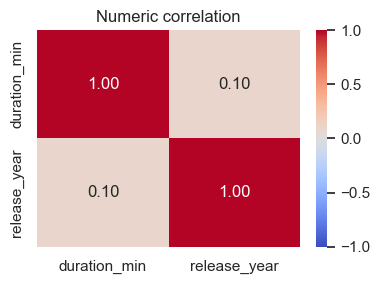

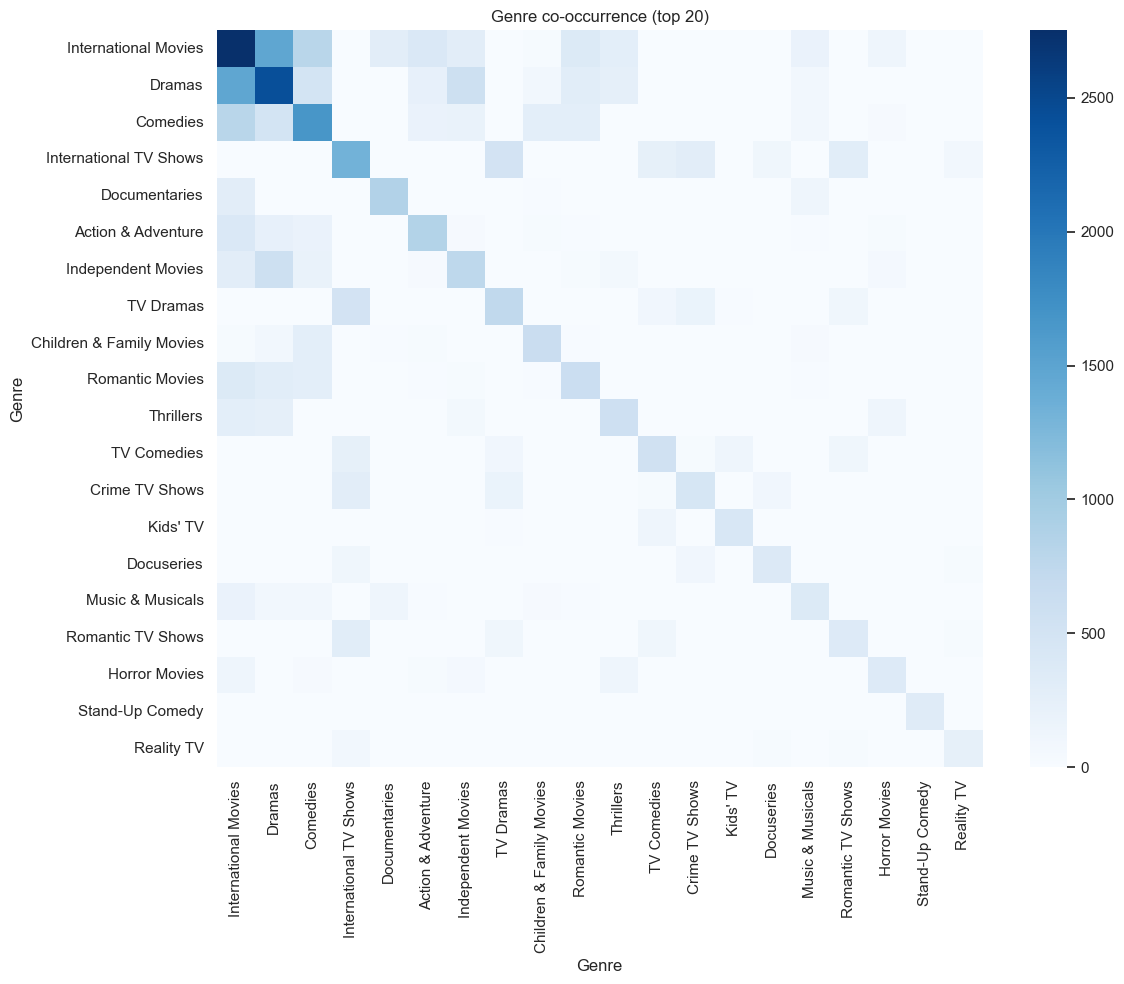

In [17]:
# ----- Numeric correlation: duration_min vs release_year -----
df_num = df[["duration_min","release_year"]].dropna()
print(df_num.corr())

plt.figure(figsize=(4,3))
sns.heatmap(df_num.corr(), annot=True, fmt=".2f", vmin=-1, vmax=1, cmap="coolwarm")
plt.title("Numeric correlation")
plt.tight_layout()
plt.show()

# ----- Genre co-occurrence (symmetric heatmap; top 20 genres) -----
# Count individual genre frequencies
genres_flat = df.explode("listed_in_list")["listed_in_list"].dropna()
topN = 20
top_genres = genres_flat.value_counts().head(topN).index.tolist()

co_mat = pd.DataFrame(0, index=top_genres, columns=top_genres, dtype=int)
for gs in df["listed_in_list"]:
    if not gs: 
        continue
    u = sorted(set([g for g in gs if g in top_genres]))
    for a, b in combinations(u, 2):
        co_mat.loc[a, b] += 1
        co_mat.loc[b, a] += 1

freq = genres_flat[genres_flat.isin(top_genres)].value_counts()
for g in top_genres:
    co_mat.loc[g, g] = int(freq.get(g, 0))

plt.figure(figsize=(12,10))
sns.heatmap(co_mat, cmap="Blues")
plt.title(f"Genre co-occurrence (top {topN})")
plt.xlabel("Genre")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()


4) NLP Representations (TF-IDF + GloVe)

**Why:** Two complementary signals
- **TF-IDF** → precise phrases/franchises
- **Genre TF-IDF**: weighted sparse matrix (`Xg_tfidf`) for cosine similarity
- **GloVe** → semantic similarity (synonyms, paraphrases)

In [18]:

nltk.download('stopwords', quiet=True)
stop = set(stopwords.words("english"))
token_pat = re.compile(r"[A-Za-z0-9_]+")

def tokenize(text: str):
    toks = token_pat.findall(str(text).lower())
    return [t for t in toks if t not in stop and len(t) > 2]

# --- TF-IDF ---
tfidf_text = TfidfVectorizer(
    token_pattern=r"(?u)\b\w\w+\b",
    stop_words="english",
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.9
)
X_tfidf = tfidf_text.fit_transform(df["text"].fillna(""))

# Genre TF-IDF (underscore tokens)
genre_docs = df["listed_in_list"].apply(normalize_genres)
tfidf_g = TfidfVectorizer(token_pattern=r"[^ ]+")
Xg_tfidf = tfidf_g.fit_transform(genre_docs.fillna(""))
# --- GLOVE EMBEDDINGS ---

glove_path = "wiki_giga_2024_100_MFT20_vectors_seed_2024_alpha_0.75_eta_0.05.050_combined.txt"
kv_path    = "wiki_giga_2024_100.kv"

if not os.path.exists(kv_path):
    emb_kv = KeyedVectors.load_word2vec_format(glove_path, binary=False, no_header=True)
    emb_kv.save(kv_path)

emb_kv = KeyedVectors.load(kv_path, mmap='r')
print(f"Embeddings loaded: {len(emb_kv.key_to_index):,} tokens | dim={emb_kv.vector_size}")

def doc_vec(text: str) -> np.ndarray:
    toks = tokenize(text)
    vecs = [emb_kv[w] for w in toks if w in emb_kv.key_to_index]
    if not vecs:
        return np.zeros(emb_kv.vector_size, dtype=np.float32)
    return np.mean(vecs, axis=0, dtype=np.float32)

emb_matrix = np.vstack([doc_vec(t) for t in df["text"].fillna("")]).astype(np.float32, copy=False)

Embeddings loaded: 1,291,147 tokens | dim=100


5) Unsupervised Models: KMeans, HDBSCAN, NMF

- **KMeans**: balanced partitions but **forces k** (risk: over/under-segmentation).
- **HDBSCAN**: discovers **natural densities** and flags **noise**—good for **sparse/niche** titles.
- Compare clusters to **type/genre** via **NMI/ARI** for interpretability.


In [19]:
Xn = normalize(X_tfidf)
ks = list(range(6, 31, 4))
sil, ch, models = [], [], {}
for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(Xn)
    models[k] = km
    sil.append(silhouette_score(Xn, labels, metric="euclidean"))
    ch.append(calinski_harabasz_score(Xn.toarray() if hasattr(Xn,'toarray') else Xn, labels))

best_k = ks[int(np.argmax(sil))]
kmeans = models[best_k]
df["cluster_km"] = kmeans.labels_
print("Chosen k (silhouette):", best_k)

# External validation (not for training)

top_genre = df["listed_in_list"].apply(lambda xs: xs[0] if xs else "Unknown")
nmi_type = normalized_mutual_info_score(df["type"], df["cluster_km"])
nmi_genr = normalized_mutual_info_score(top_genre, df["cluster_km"])
ari_genr = adjusted_rand_score(top_genre, df["cluster_km"])
print("NMI(type,cluster)=", round(nmi_type,3),
      " NMI(genre,cluster)=", round(nmi_genr,3),
      " ARI(genre,cluster)=", round(ari_genr,3))


Chosen k (silhouette): 30
NMI(type,cluster)= 0.275  NMI(genre,cluster)= 0.631  ARI(genre,cluster)= 0.405


Clustering (KMeans on TF-IDF): I selected k=30 via silhouette maximization. External validation against metadata shows (Normalized Mutual Information) NMI=0.631 and  (Adjusted Rand Index) ARI=0.405 w.r.t. top genre, indicating strong thematic coherence, while NMI=0.275 w.r.t. type suggests clusters are not trivially driven by Movie vs TV. 

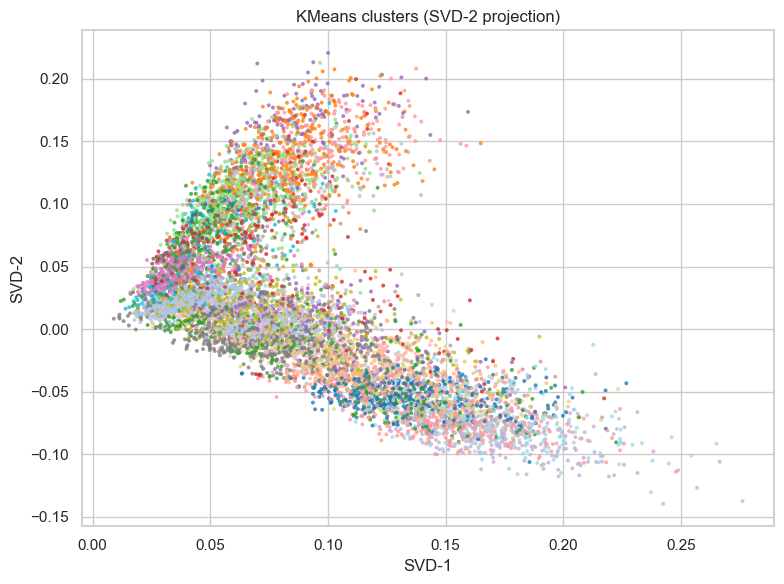

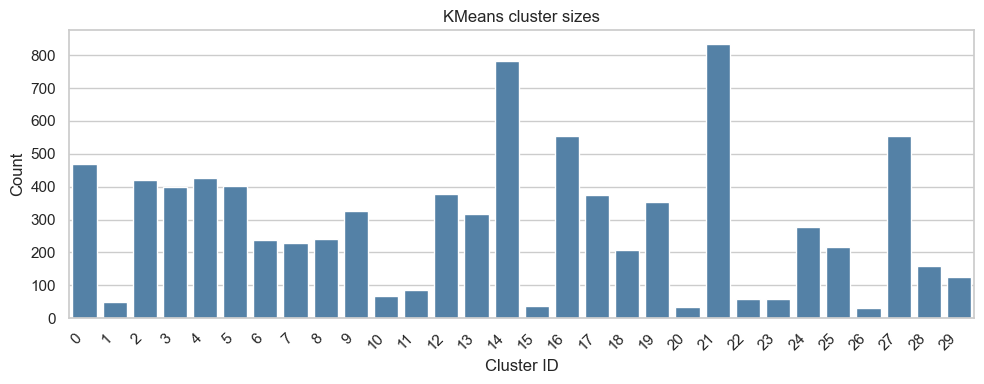

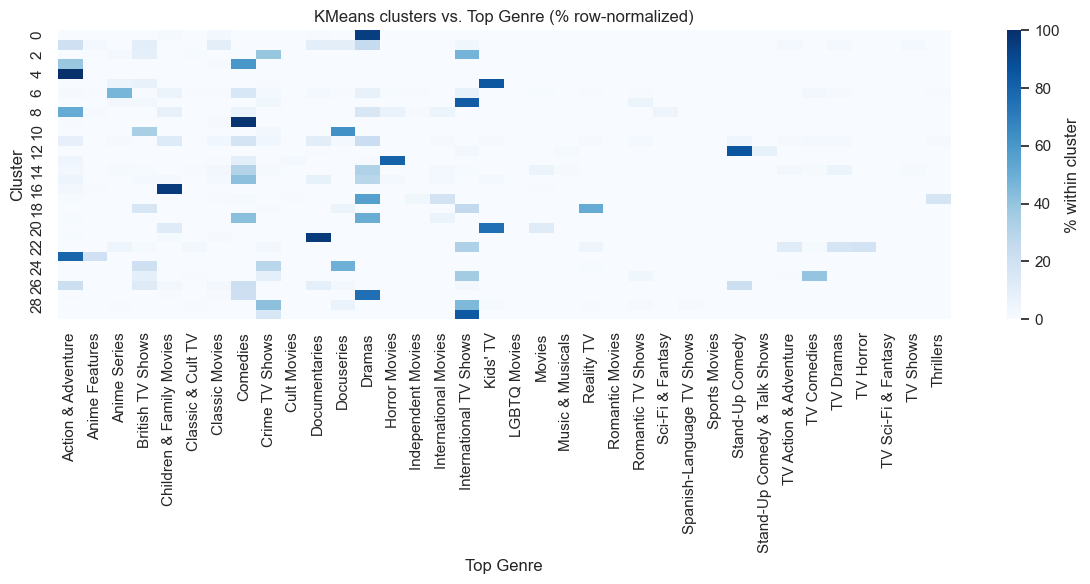

,cluster,top_terms
0,0,"dramas international_movies, dramas, internati..."
1,1,"world war, war ii, ii, war, world, dramas, sol..."
2,2,"international_tv_shows tv_dramas, tv_dramas, i..."
3,3,"comedies international_movies, comedies, actio..."
4,4,"action_and_adventure, action_and_adventure dra..."
5,5,"kids, _tv, kids _tv, _tv tv_comedies, tv_comed..."
6,6,"high, school, high school, anime_series intern..."
7,7,"international_tv_shows romantic_tv_shows, roma..."
8,8,"sci, sci fi_and_fantasy, fi_and_fantasy, actio..."
9,9,"comedies dramas, comedies, dramas internationa..."


In [20]:
svd2 = TruncatedSVD(n_components=2, random_state=42)
X_2d = svd2.fit_transform(X_tfidf)

plot_df = pd.DataFrame({
    "x": X_2d[:,0], "y": X_2d[:,1],
    "cluster": df["cluster_km"].astype(int).values
})

plt.figure(figsize=(8,6))
sns.scatterplot(data=plot_df, x="x", y="y", hue="cluster",
                palette="tab20", s=8, linewidth=0, alpha=0.8, legend=False)
plt.title("KMeans clusters (SVD-2 projection)")
plt.xlabel("SVD-1"); plt.ylabel("SVD-2")
plt.tight_layout(); plt.show()

# 2) Cluster size bar chart
sizes = (df["cluster_km"].value_counts()
         .rename_axis("cluster").reset_index(name="count")
         .sort_values("count", ascending=False))

plt.figure(figsize=(10,4))
sns.barplot(data=sizes, x="cluster", y="count", color="steelblue")
plt.title("KMeans cluster sizes")
plt.xlabel("Cluster ID"); plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout(); plt.show()

# 3) Cluster × top-genre heatmap (how genre-aligned are clusters?)
top_genre = df["listed_in_list"].apply(lambda xs: xs[0] if xs else "Unknown")
ct = (pd.crosstab(df["cluster_km"], top_genre, normalize="index") * 100.0)

plt.figure(figsize=(12,6))
sns.heatmap(ct, cmap="Blues", cbar_kws={"label":"% within cluster"})
plt.title("KMeans clusters vs. Top Genre (% row-normalized)")
plt.xlabel("Top Genre"); plt.ylabel("Cluster")
plt.tight_layout(); plt.show()

# 4) Top TF-IDF terms per cluster (quick textual summary)
feature_names = np.array(tfidf_text.get_feature_names_out())
centers = kmeans.cluster_centers_
topn = 10

def top_terms_per_cluster(centers, feature_names, topn=10):
    rows = []
    for cid, row in enumerate(centers):
        terms = feature_names[np.argsort(-row)[:topn]]
        rows.append({"cluster": cid, "top_terms": ", ".join(terms)})
    return pd.DataFrame(rows).sort_values("cluster")

km_terms = top_terms_per_cluster(centers, feature_names, topn=10)
km_terms.head(10)

5.1 HDBSCAN on embeddings (density + noise)
Tuning `min_cluster_size` trades off **coverage** vs **specificity**.


In [21]:

svd = TruncatedSVD(n_components=200, random_state=42)
X_svd = svd.fit_transform(X_tfidf)

best, best_model = (-np.inf, None), None
for mcs in [5, 10, 15, 20]:
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=mcs,
        min_samples=None,
        metric="euclidean",
        cluster_selection_method="leaf"
    ).fit(X_svd)

    labels = clusterer.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    prop = (labels != -1).mean()
    score = prop * max(n_clusters, 1)
    if score > best[0]:
        best = (score, mcs, n_clusters, prop)
        best_model = clusterer

df["cluster_hdb"] = best_model.labels_
print(f"HDBSCAN (SVD200) → min_cluster_size={best[1]}, "
      f"clusters={best[2]}, noise={1-best[3]:.2f}")


/Users/zj/Documents/Paladigm_code/finnhub/.conda/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/zj/Documents/Paladigm_code/finnhub/.conda/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/zj/Documents/Paladigm_code/finnhub/.conda/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/zj/Documents/Paladigm_code/finnhub/.conda/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/zj/Documents/Paladigm_code/finnhub/.conda/lib/python3.11/site

HDBSCAN (SVD200) → min_cluster_size=5, clusters=27, noise=0.95


Clusters represent small, high-density pockets; the model treats most titles as isolated under the chosen geometry—consistent with a long-tail catalog.
KMeans captured broader, genre-aligned structure (NMI=0.631), while HDBSCAN isolated niche subcommunities. I use KMeans for global segmentation and HDBSCAN clusters as high-precision seeds in the recommender/analytics.

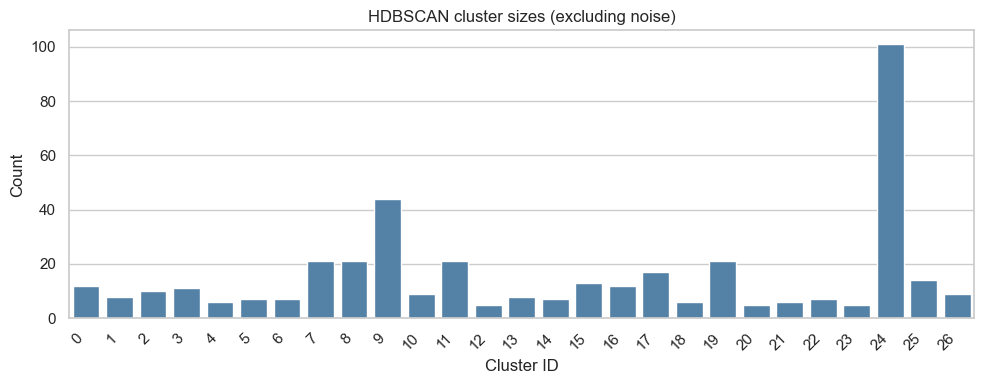

Noise proportion: 0.9525777930876105


In [22]:
sizes = (df["cluster_hdb"][df["cluster_hdb"] != -1]
         .value_counts()
         .rename_axis("cluster")
         .reset_index(name="count")
         .sort_values("count", ascending=False))

plt.figure(figsize=(10,4))
sns.barplot(data=sizes, x="cluster", y="count", color="steelblue")
plt.title("HDBSCAN cluster sizes (excluding noise)")
plt.xlabel("Cluster ID"); plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

print("Noise proportion:", (df["cluster_hdb"] == -1).mean())

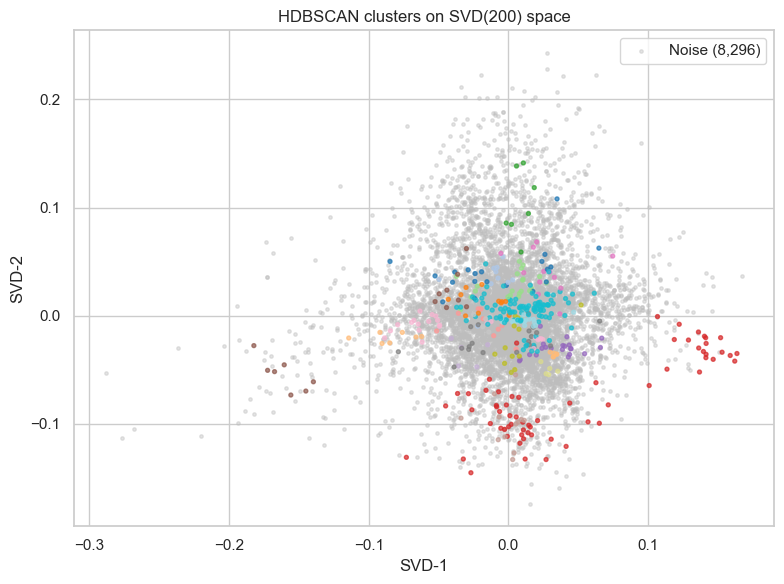

In [23]:
xy = pd.DataFrame({
    "x": X_svd[:, 24],
    "y": X_svd[:, 9],
    "label": df["cluster_hdb"].astype(int)
})

# Split noise vs clustered for clarity
noise = xy[xy["label"] == -1]
clust = xy[xy["label"] != -1]

plt.figure(figsize=(8,6))
# noise
plt.scatter(noise["x"], noise["y"], s=6, c="#bdbdbd", alpha=0.4, label=f"Noise ({len(noise):,})")
# clusters (colored by label)
scatter = plt.scatter(clust["x"], clust["y"], s=8, c=clust["label"], cmap="tab20", alpha=0.7)
plt.title("HDBSCAN clusters on SVD(200) space")
plt.xlabel("SVD-1"); plt.ylabel("SVD-2")
plt.legend(loc="best", frameon=True)
plt.tight_layout()
plt.show()

Topic Modeling (NMF) on TF-IDF
Topics help **name** cluster themes and cut across genre/type lines.


In [24]:
n_topics = 12
nmf = NMF(n_components=n_topics, random_state=42, init="nndsvd", max_iter=400)
W = nmf.fit_transform(X_tfidf)
H = nmf.components_
df["topic_nmf"] = W.argmax(axis=1)

feature_names = np.array(tfidf_text.get_feature_names_out())
def top_terms(H, topn=12):
    for i, comp in enumerate(H):
        terms = feature_names[np.argsort(-comp)[:topn]]
        print(f"Topic {i:02d}:", ", ".join(terms))
top_terms(H)


Topic 00: dramas international_movies, dramas, international_movies, comedies dramas, young, action_and_adventure dramas, man, action_and_adventure, woman, family, father, life
Topic 01: international_tv_shows, crime_tv_shows, tv_dramas, crime_tv_shows international_tv_shows, international_tv_shows tv_dramas, spanish, language_tv_shows, spanish language_tv_shows, international_tv_shows spanish, murder, family, tv_action_and_adventure
Topic 02: kids, kids _tv, _tv, _tv tv_comedies, tv_comedies, friends, adventures, rangers, power, series, world, fun
Topic 03: stand, stand up_comedy, up_comedy, special, comedian, comedy, stand special, comic, special stand, stage, live, takes
Topic 04: independent_movies, dramas independent_movies, independent_movies international_movies, dramas, international_movies, young, comedies dramas, man, life, father, independent_movies thrillers, family
Topic 05: documentaries, documentary, documentaries international_movies, music_and_musicals, international_m

6) Content-Based Recommender (Unsupervised)
This recommender is fully content-based: for a seed title (or text query) we compute four similarities to every other title—TF-IDF cosine on title+description text, GloVe embedding cosine (average token vectors), genre TF-IDF cosine (from macro_genres), and genre Jaccard overlap. We min–max normalize the cosine scores per query and blend them with weights into a hybrid score; optional small nudges boost items in the same KMeans/HDBSCAN cluster or NMF topic. Finally, we apply optional filters (e.g., same_type, year_window), suppress the seed itself, and return the top-k by score. All matrices are rebuilt after df.reset_index(drop=True) to keep row alignment.
**Signals**
- Cosine **TF-IDF (text)**
- Cosine **GloVe (embeddings)**
- Cosine **genre-TF-IDF**
- **Jaccard** over genre sets

**Hybrid** score: a combination of other scores and cluster values from above

**Notes**
- TF-IDF is crisp and franchise-aware.
- Embeddings are semantic (recall), but may drift off-genre.
- Genre features keep results on-genre; Jaccard is interpretable.


In [25]:
def _safe_list_to_str(series):
    return series.apply(lambda xs: ", ".join(xs) if isinstance(xs, list) else "")

def _ensure_col_or_from_list(df, col_name, list_name):
    """Return a NumPy array of strings: use df[col_name] if present;
    otherwise build from df[list_name] (list → comma-separated)."""
    if col_name in df.columns:
        return df[col_name].fillna("").astype(str).to_numpy()
    elif list_name in df.columns:
        return _safe_list_to_str(df[list_name]).to_numpy()
    else:
        return np.array([""] * len(df), dtype=object)

def _minmax(x: np.ndarray) -> np.ndarray:
    """Min-max normalization"""
    x = np.asarray(x, dtype=np.float32)
    m, M = np.nanmin(x), np.nanmax(x)
    if not np.isfinite(m) or not np.isfinite(M) or M <= m:
        return np.zeros_like(x, dtype=np.float32)
    return (x - m) / (M - m + 1e-9)

In [26]:
def recommend(
    title: str,
    k: int = 10,
    method: str = "tfidf",
    weights=(0.5, 0.3, 0.15, 0.05),          # (TFIDF, Emb, GenreTFIDF, Jaccard)
    cluster_weights=(0.08, 0.05, 0.10),      # (λ_km, λ_hdb, λ_topic)
    same_type: bool = True,
    year_window: int | None = None,
    W_topics=None                            
):
    """Consolidated recommendation function with all similarity methods"""
    # Find the seed row
    idxs = df.index[df["title"].str.lower() == title.lower()]
    if len(idxs) == 0:
        raise ValueError(f"Title not found: {title}")
    i = int(idxs[0])

    # Core similarities
    st = cosine_similarity(X_tfidf[i], X_tfidf).ravel().astype(np.float32)
    se = cosine_similarity(emb_matrix[i].reshape(1, -1), emb_matrix).ravel().astype(np.float32)
    sg = cosine_similarity(Xg_tfidf[i], Xg_tfidf).ravel().astype(np.float32)

    # Jaccard over genres
    A = set(df.iloc[i]["listed_in_list"] or [])
    sj = np.empty(len(df), dtype=np.float32)
    for j in range(len(df)):
        if j == i:
            sj[j] = -1.0
            continue
        B = set(df.iloc[j]["listed_in_list"] or [])
        denom = len(A | B)
        sj[j] = (len(A & B) / denom) if denom else 0.0

    # Choose base score by method
    if method == "tfidf":
        score = st
    elif method == "embed":
        score = se
    elif method == "genre":
        score = sg
    elif method == "hybrid":
        score = (
            weights[0] * _minmax(st)
            + weights[1] * _minmax(se)
            + weights[2] * _minmax(sg)
            + weights[3] * sj
        ).astype(np.float32, copy=False)
    else:
        raise ValueError("Unknown method; use 'tfidf', 'embed', 'genre', or 'hybrid'.")

    # Cluster/topic boosters (soft nudges)
    km_labels   = df["cluster_km"].to_numpy()   if "cluster_km"  in df.columns else None
    hdb_labels  = df["cluster_hdb"].to_numpy()  if "cluster_hdb" in df.columns else None
    topic_hard  = df["topic_nmf"].to_numpy()    if "topic_nmf"   in df.columns else None

    # KMeans cluster boost
    if km_labels is not None:
        li = km_labels[i]
        s_km = (km_labels == li).astype(np.float32)
        s_km[i] = 0.0
        score += cluster_weights[0] * s_km

    # HDBSCAN cluster boost
    if hdb_labels is not None:
        li = hdb_labels[i]
        s_hdb = np.zeros(len(df), dtype=np.float32)
        for j in range(len(df)):
            if j == i:
                s_hdb[j] = 0.0
            elif hdb_labels[j] == -1:
                s_hdb[j] = 0.2  # noise penalty
            elif li != -1 and hdb_labels[j] == li:
                s_hdb[j] = 1.0
        score += cluster_weights[1] * s_hdb

    # Topic boost
    if W_topics is not None:
        vi = W_topics[i].reshape(1, -1)
        s_topic = cosine_similarity(vi, W_topics).ravel().astype(np.float32)
        score += cluster_weights[2] * _minmax(s_topic)
    elif topic_hard is not None:
        li = topic_hard[i]
        s_topic = (topic_hard == li).astype(np.float32)
        score += cluster_weights[2] * s_topic

    # Never recommend the seed itself
    score[i] = -1.0

    # Optional constraints
    if same_type:
        qtype = df.iloc[i]["type"]
        type_arr = df["type"].to_numpy()
        score[type_arr != qtype] = -1.0

    if year_window and pd.notna(df.iloc[i]["release_year"]):
        y0 = int(df.iloc[i]["release_year"])
        ry = df["release_year"].to_numpy(dtype=np.float32, copy=False)
        year_mask = np.isfinite(ry) & (ry >= y0 - year_window) & (ry <= y0 + year_window)
        score[~year_mask] = -1.0

    # Top-k
    top = np.argsort(-score)[:k]

    # Build output safely
    listed_in_str = _ensure_col_or_from_list(df, "listed_in", "listed_in_list")
    country_str   = _ensure_col_or_from_list(df, "country", "country_list")
    rating_str    = df["rating"].astype(str).to_numpy() if "rating" in df.columns else np.array([""]*len(df))

    out = df.iloc[top][["title", "type", "release_year"]].copy()
    out.insert(3, "rating",     rating_str[top])
    out.insert(4, "listed_in",  listed_in_str[top])
    out.insert(5, "country",    country_str[top])
    out["score"] = score[top]
    return out

def search_and_recommend(
    query: str,
    k: int = 10,
    method: str = "hybrid",
    w=(0.6, 0.4),
    same_type: str | None = None
):
    vq  = tfidf_text.transform([query.lower()])
    stq = cosine_similarity(vq, X_tfidf).ravel().astype(np.float32)

    toks = tokenize(query)
    vecs = [emb_kv[w] for w in toks if w in emb_kv.key_to_index]
    vqe = (np.mean(vecs, axis=0) if len(vecs) else np.zeros(emb_kv.vector_size, dtype=np.float32)).reshape(1, -1)
    seq = cosine_similarity(vqe, emb_matrix).ravel().astype(np.float32)

    if method == "tfidf":
        score = stq
    elif method == "embed":
        score = seq
    elif method == "hybrid":
        score = w[0] * _minmax(stq) + w[1] * _minmax(seq)
    else:
        raise ValueError("Unknown method; use 'tfidf', 'embed', or 'hybrid'.")

    if same_type in {"Movie", "TV Show"}:
        type_arr = df["type"].to_numpy()
        score[type_arr != same_type] = -1.0

    top = np.argsort(-score)[:k]

    listed_in_str = _ensure_col_or_from_list(df, "listed_in", "listed_in_list")
    out = df.iloc[top][["title", "type", "release_year"]].copy()
    out.insert(3, "listed_in", listed_in_str[top])
    out["score"] = score[top]
    return out

**7. Demo: Content-Based Recommendations**

Testing the recommendation system with different methods and examples.

In [27]:

# helper: auto-pass W if it exists
def _maybe_W():
    try:
        return W  # NMF doc-topic matrix if you kept it
    except NameError:
        return None

def show_title_recs(
    title,
    k=10,
    weights=(0.5, 0.3, 0.15, 0.05),        # TFIDF, Emb, GenreTFIDF, Jaccard
    cluster_weights=(0.08, 0.05, 0.10),    # λ_km, λ_hdb, λ_topic
    year_window=None,
    same_type=True,
):
    idxs = df.index[df["title"].str.lower() == title.lower()]
    if len(idxs) == 0:
        print(f"❌ Title not found: {title}\n")
        matches = df[df["title"].str.lower().str.contains(title.lower(), na=False)].title.head(10).tolist()
        if matches:
            print("Did you mean:\n  - " + "\n  - ".join(matches))
        return

    print(f"\n🔎 Seed: {title}")

    print("— TF-IDF —")
    display(recommend(
        title, k=k, method="tfidf",
        same_type=same_type, year_window=year_window
    ))

    print("\n— Embeddings (GloVe) —")
    display(recommend(
        title, k=k, method="embed",
        same_type=same_type, year_window=year_window
    ))

    print("\n— Hybrid (with cluster/topic nudges) —")
    display(recommend(
        title, k=k, method="hybrid",
        weights=weights,
        cluster_weights=cluster_weights,
        same_type=same_type,
        year_window=year_window,
        W_topics=_maybe_W()
    ))

def show_text_query(
    query,
    k=10,
    same_type=None,
    w=(0.6, 0.4) 
):
    print(f"\n📝 Text query: “{query}”")
    display(search_and_recommend(query, k=k, method="hybrid", w=w, same_type=same_type))

# ---- Configure demo here ----
K = 10
WEIGHTS = (0.5, 0.3, 0.15, 0.05)    
CLUSTER_W = (0.08, 0.05, 0.10)       # (λ_km, λ_hdb, λ_topic)
YEAR_WINDOW = 8                     
SAME_TYPE = True                     # Movie→Movie, TV→TV

try:
    show_title_recs("Sherlock", k=K, weights=WEIGHTS, cluster_weights=CLUSTER_W,
                    year_window=YEAR_WINDOW, same_type=SAME_TYPE)

    show_title_recs("Breaking Bad", k=K, weights=WEIGHTS, cluster_weights=CLUSTER_W,
                    year_window=YEAR_WINDOW, same_type=SAME_TYPE)

    show_title_recs("Stranger Things", k=K, weights=WEIGHTS, cluster_weights=CLUSTER_W,
                    year_window=YEAR_WINDOW, same_type=SAME_TYPE)

    show_text_query("british crime investigation series", k=K, same_type=None, w=(0.6, 0.4))

except Exception as e:
    print("Demo skipped due to error:", repr(e))


🔎 Seed: Sherlock
— TF-IDF —


,title,type,release_year,rating,listed_in,country,score
1166,The Irregulars,TV Show,2021,TV-14,"British TV Shows, Crime TV Shows, Internationa...",United Kingdom,0.433644
3524,Top Boy,TV Show,2019,TV-MA,"British TV Shows, Crime TV Shows, Internationa...",,0.407422
5032,The Frankenstein Chronicles,TV Show,2017,TV-MA,"British TV Shows, Crime TV Shows, Internationa...",United Kingdom,0.375607
6930,Hinterland,TV Show,2016,TV-14,"British TV Shows, Crime TV Shows, Internationa...",United Kingdom,0.372181
1991,Criminal: UK,TV Show,2020,TV-MA,"British TV Shows, Crime TV Shows, Internationa...","United Kingdom, France, Germany, Spain",0.371634
523,Marcella,TV Show,2019,TV-MA,"British TV Shows, Crime TV Shows, Internationa...",United Kingdom,0.365602
5716,Paranoid,TV Show,2016,TV-MA,"British TV Shows, Crime TV Shows, Internationa...",United Kingdom,0.363450
6100,Agent Raghav,TV Show,2015,TV-14,"Crime TV Shows, International TV Shows, TV Act...",India,0.360800
3034,Giri / Haji,TV Show,2019,TV-MA,"British TV Shows, Crime TV Shows, Internationa...",United Kingdom,0.358550
4992,Collateral,TV Show,2018,TV-MA,"British TV Shows, Crime TV Shows, Internationa...","United Kingdom, United States",0.348350



— Embeddings (GloVe) —


,title,type,release_year,rating,listed_in,country,score
5032,The Frankenstein Chronicles,TV Show,2017,TV-MA,"British TV Shows, Crime TV Shows, Internationa...",United Kingdom,1.063706
5674,Merlin,TV Show,2012,TV-PG,"British TV Shows, International TV Shows, TV A...",United Kingdom,1.060581
7070,Jack Taylor,TV Show,2016,TV-MA,"Crime TV Shows, International TV Shows, TV Dramas","United States, Ireland",1.052748
1166,The Irregulars,TV Show,2021,TV-14,"British TV Shows, Crime TV Shows, Internationa...",United Kingdom,1.039497
2783,Freud,TV Show,2020,TV-MA,"Crime TV Shows, International TV Shows, TV Dramas","Austria, Germany",1.035107
5150,Broadchurch,TV Show,2017,TV-MA,"British TV Shows, Crime TV Shows, Internationa...",United Kingdom,1.030028
5297,FINAL FANTASY XIV Dad of Light,TV Show,2017,TV-PG,"International TV Shows, TV Dramas",Japan,1.021859
3855,The Writer,TV Show,2019,TV-14,"Crime TV Shows, International TV Shows, TV Dramas",Lebanon,1.021839
2546,Bordertown,TV Show,2019,TV-MA,"Crime TV Shows, International TV Shows, TV Dramas","Finland, France",1.018923
523,Marcella,TV Show,2019,TV-MA,"British TV Shows, Crime TV Shows, Internationa...",United Kingdom,1.017670



— Hybrid (with cluster/topic nudges) —


,title,type,release_year,rating,listed_in,country,score
1166,The Irregulars,TV Show,2021,TV-14,"British TV Shows, Crime TV Shows, Internationa...",United Kingdom,0.731562
5032,The Frankenstein Chronicles,TV Show,2017,TV-MA,"British TV Shows, Crime TV Shows, Internationa...",United Kingdom,0.715698
6930,Hinterland,TV Show,2016,TV-14,"British TV Shows, Crime TV Shows, Internationa...",United Kingdom,0.687128
523,Marcella,TV Show,2019,TV-MA,"British TV Shows, Crime TV Shows, Internationa...",United Kingdom,0.685725
3524,Top Boy,TV Show,2019,TV-MA,"British TV Shows, Crime TV Shows, Internationa...",,0.678776
5150,Broadchurch,TV Show,2017,TV-MA,"British TV Shows, Crime TV Shows, Internationa...",United Kingdom,0.669720
5716,Paranoid,TV Show,2016,TV-MA,"British TV Shows, Crime TV Shows, Internationa...",United Kingdom,0.663267
7284,London Spy,TV Show,2015,TV-MA,"British TV Shows, Crime TV Shows, Internationa...",United Kingdom,0.662373
3034,Giri / Haji,TV Show,2019,TV-MA,"British TV Shows, Crime TV Shows, Internationa...",United Kingdom,0.657699
8249,The Great Train Robbery,TV Show,2013,NR,"British TV Shows, Crime TV Shows, Internationa...",United Kingdom,0.654800



🔎 Seed: Breaking Bad
— TF-IDF —


,title,type,release_year,rating,listed_in,country,score
1477,Dare Me,TV Show,2019,TV-MA,"Crime TV Shows, TV Dramas, TV Thrillers",United States,0.340268
2767,Ozark,TV Show,2020,TV-MA,"Crime TV Shows, TV Dramas, TV Thrillers",United States,0.333555
7394,Merlí,TV Show,2015,TV-MA,"International TV Shows, TV Dramas, Teen TV Shows",Spain,0.321921
4664,Age of Rebellion,TV Show,2018,TV-MA,"Crime TV Shows, International TV Shows, TV Dramas",Taiwan,0.314884
1587,Detention,TV Show,2020,TV-MA,"International TV Shows, TV Dramas, TV Horror",Taiwan,0.310525
1067,The Underclass,TV Show,2020,TV-MA,"International TV Shows, TV Dramas, Teen TV Shows",Thailand,0.310164
2931,Better Call Saul,TV Show,2018,TV-MA,"Crime TV Shows, TV Comedies, TV Dramas",United States,0.303342
8310,The Lizzie Borden Chronicles,TV Show,2015,TV-14,"Crime TV Shows, TV Dramas, TV Thrillers",United States,0.302779
3801,WHAT / IF,TV Show,2019,TV-MA,"TV Dramas, TV Thrillers",United States,0.297655
1955,The School Nurse Files,TV Show,2020,TV-MA,"International TV Shows, TV Dramas, TV Mysteries",South Korea,0.292829



— Embeddings (GloVe) —


,title,type,release_year,rating,listed_in,country,score
1067,The Underclass,TV Show,2020,TV-MA,"International TV Shows, TV Dramas, Teen TV Shows",Thailand,1.117169
1955,The School Nurse Files,TV Show,2020,TV-MA,"International TV Shows, TV Dramas, TV Mysteries",South Korea,1.091845
7394,Merlí,TV Show,2015,TV-MA,"International TV Shows, TV Dramas, Teen TV Shows",Spain,1.087723
2230,Kissing Game,TV Show,2020,TV-MA,"International TV Shows, TV Dramas, TV Mysteries",Brazil,1.082574
3755,Jinn,TV Show,2019,TV-MA,"International TV Shows, TV Dramas, TV Mysteries",Jordan,1.076819
5038,Re:Mind,TV Show,2017,TV-MA,"International TV Shows, TV Dramas, TV Mysteries",Japan,1.076179
6709,Fairy Tail,TV Show,2009,TV-MA,"Anime Series, International TV Shows",Japan,1.075663
5751,DEATH NOTE,TV Show,2006,TV-14,"Anime Series, Crime TV Shows, International TV...",Japan,1.075399
4664,Age of Rebellion,TV Show,2018,TV-MA,"Crime TV Shows, International TV Shows, TV Dramas",Taiwan,1.067506
3219,Levius,TV Show,2019,TV-14,"Anime Series, International TV Shows",Japan,1.062822



— Hybrid (with cluster/topic nudges) —


,title,type,release_year,rating,listed_in,country,score
1477,Dare Me,TV Show,2019,TV-MA,"Crime TV Shows, TV Dramas, TV Thrillers",United States,0.738951
2767,Ozark,TV Show,2020,TV-MA,"Crime TV Shows, TV Dramas, TV Thrillers",United States,0.624394
4664,Age of Rebellion,TV Show,2018,TV-MA,"Crime TV Shows, International TV Shows, TV Dramas",Taiwan,0.594439
3762,Designated Survivor,TV Show,2019,TV-MA,"Crime TV Shows, TV Dramas, TV Thrillers",United States,0.583311
1980,The Blacklist,TV Show,2019,TV-14,"Crime TV Shows, TV Dramas, TV Thrillers",United States,0.576071
2133,Teenage Bounty Hunters,TV Show,2020,TV-MA,"Crime TV Shows, TV Comedies, TV Dramas",United States,0.565890
3801,WHAT / IF,TV Show,2019,TV-MA,"TV Dramas, TV Thrillers",United States,0.547669
1067,The Underclass,TV Show,2020,TV-MA,"International TV Shows, TV Dramas, Teen TV Shows",Thailand,0.547340
678,The Assassination of Gianni Versace,TV Show,2018,TV-MA,"Crime TV Shows, TV Dramas, TV Thrillers",United States,0.547082
33,Squid Game,TV Show,2021,TV-MA,"International TV Shows, TV Dramas, TV Thrillers",,0.539684



🔎 Seed: Stranger Things
— TF-IDF —


,title,type,release_year,rating,listed_in,country,score
3187,Nightflyers,TV Show,2018,TV-MA,"TV Horror, TV Mysteries, TV Sci-Fi & Fantasy",United States,0.475446
6915,Helix,TV Show,2015,TV-MA,"TV Horror, TV Mysteries, TV Sci-Fi & Fantasy","United States, Canada",0.426902
1473,Chilling Adventures of Sabrina,TV Show,2020,TV-14,"TV Horror, TV Mysteries, TV Sci-Fi & Fantasy",United States,0.377499
241,Manifest,TV Show,2021,TV-14,"TV Dramas, TV Mysteries, TV Sci-Fi & Fantasy",United States,0.355616
883,"Love, Death & Robots",TV Show,2021,TV-MA,"TV Action & Adventure, TV Horror, TV Sci-Fi & ...",United States,0.346074
4320,Neo Yokio,TV Show,2018,TV-MA,"TV Comedies, TV Sci-Fi & Fantasy, Teen TV Shows",United States,0.309129
886,The Mystic River,TV Show,2020,TV-14,"International TV Shows, TV Horror, TV Sci-Fi &...",,0.307596
3986,The OA,TV Show,2019,TV-MA,"TV Dramas, TV Mysteries, TV Sci-Fi & Fantasy",United States,0.303785
5200,Beyond Stranger Things,TV Show,2017,TV-14,"Stand-Up Comedy & Talk Shows, TV Mysteries, TV...",United States,0.295752
737,Trese,TV Show,2021,TV-MA,"Anime Series, Crime TV Shows, TV Horror","Philippines, Singapore, Indonesia",0.294501



— Embeddings (GloVe) —


,title,type,release_year,rating,listed_in,country,score
1473,Chilling Adventures of Sabrina,TV Show,2020,TV-14,"TV Horror, TV Mysteries, TV Sci-Fi & Fantasy",United States,1.112070
886,The Mystic River,TV Show,2020,TV-14,"International TV Shows, TV Horror, TV Sci-Fi &...",,1.102241
883,"Love, Death & Robots",TV Show,2021,TV-MA,"TV Action & Adventure, TV Horror, TV Sci-Fi & ...",United States,1.043038
4163,Z Nation,TV Show,2018,TV-MA,"TV Action & Adventure, TV Comedies, TV Horror",United States,1.035769
8334,The Messengers,TV Show,2015,TV-14,"TV Dramas, TV Mysteries, TV Sci-Fi & Fantasy",United States,1.030874
2600,Good Witch,TV Show,2019,TV-PG,"TV Dramas, TV Sci-Fi & Fantasy","United States, Canada",1.029171
3986,The OA,TV Show,2019,TV-MA,"TV Dramas, TV Mysteries, TV Sci-Fi & Fantasy",United States,1.023550
4023,The Land of Hypocrisy,TV Show,2018,TV-14,"International TV Shows, TV Comedies, TV Sci-Fi...",Egypt,1.022956
1127,Prank Encounters,TV Show,2021,TV-MA,"Reality TV, TV Comedies, TV Horror",United States,1.021847
2297,JU-ON: Origins,TV Show,2020,TV-MA,"International TV Shows, TV Horror, TV Mysteries",Japan,1.019872



— Hybrid (with cluster/topic nudges) —


,title,type,release_year,rating,listed_in,country,score
1473,Chilling Adventures of Sabrina,TV Show,2020,TV-14,"TV Horror, TV Mysteries, TV Sci-Fi & Fantasy",United States,0.727789
3187,Nightflyers,TV Show,2018,TV-MA,"TV Horror, TV Mysteries, TV Sci-Fi & Fantasy",United States,0.695645
6915,Helix,TV Show,2015,TV-MA,"TV Horror, TV Mysteries, TV Sci-Fi & Fantasy","United States, Canada",0.683695
886,The Mystic River,TV Show,2020,TV-14,"International TV Shows, TV Horror, TV Sci-Fi &...",,0.625615
8479,ThirTEEN Terrors,TV Show,2014,TV-14,"International TV Shows, TV Horror, TV Mysteries",Thailand,0.608772
1625,The Guest,TV Show,2018,TV-14,"International TV Shows, TV Horror, TV Mysteries",South Korea,0.603309
2297,JU-ON: Origins,TV Show,2020,TV-MA,"International TV Shows, TV Horror, TV Mysteries",Japan,0.601255
4518,The Haunting of Hill House,TV Show,2018,TV-MA,"TV Dramas, TV Horror, TV Mysteries",United States,0.592191
883,"Love, Death & Robots",TV Show,2021,TV-MA,"TV Action & Adventure, TV Horror, TV Sci-Fi & ...",United States,0.588960
3986,The OA,TV Show,2019,TV-MA,"TV Dramas, TV Mysteries, TV Sci-Fi & Fantasy",United States,0.585171



📝 Text query: “british crime investigation series”


,title,type,release_year,listed_in,score
1945,Manorama Six Feet Under,Movie,2007,"Dramas, International Movies, Thrillers",0.959567
6502,Come and Find Me,Movie,2016,"Dramas, Thrillers",0.908362
8280,The Investigator: A British Crime Story,TV Show,2018,"British TV Shows, Crime TV Shows, Docuseries",0.877678
942,Mystic River,Movie,2003,"Dramas, Thrillers",0.873887
8341,The Murder Detectives,TV Show,2015,"British TV Shows, Crime TV Shows, Docuseries",0.853652
7259,Lila & Eve,Movie,2015,"Dramas, Thrillers",0.837814
1358,Shutter Island,Movie,2010,Thrillers,0.816476
514,Cuckoo,TV Show,2019,"British TV Shows, International TV Shows, TV C...",0.808038
2203,Shameless (U.S.),TV Show,2019,"TV Comedies, TV Dramas",0.791324
1510,The Con Is On,Movie,2018,Comedies,0.770538


8) Discussion & Conclusions
**Clustering**

KMeans (on TF-IDF): I selected k via silhouette sweep (best at k=30). External validation vs metadata showed NMI(type)=0.275, NMI(top-genre)=0.631, ARI(top-genre)=0.405, i.e., clusters align strongly with genre without merely splitting Movie/TV. I visualized clusters with SVD-2 scatter, sizes, and a cluster×genre heatmap, plus top TF-IDF terms per cluster.

HDBSCAN (on SVD-reduced TF-IDF, 200 comps): Found 27 compact clusters with ~95% noise at min_cluster_size=5, surfacing high-purity niches and flagging outliers—complementary to KMeans’ broader structure.

**Topics**

NMF on TF-IDF: Produced readable themes (e.g., crime/investigation, romance, stand-up). I assigned each title a dominant topic and (optionally) used the topic distribution W for cosine-topic similarity.

**Recommender (content-based, unsupervised)**

Signals: cosine TF-IDF (text), cosine GloVe avg embeddings (from local vectors), cosine genre-TF-IDF (built from macro_genres), and genre Jaccard.

Hybrid score: α·TFIDF_text + β·Embeddings + γ·TFIDF_genre + δ·Jaccard with per-signal min-max normalization.

Cluster/topic nudges: small boosts for same KMeans cluster, non-noise HDBSCAN cluster, and topic similarity (W-cosine or hard topic match). Optional same_type and year_window filters. Robust to cleaned schema (*_list fallbacks).

**Duration proxy**

Parsed mixed duration into movie minutes and TV seasons, engineered macro_genres, then estimated TV minutes = (avg episodes/season × avg minutes/episode by macro-genre). Stored provenance in duration_proxy_source. This gave a usable numeric duration_min for EDA and distance-based methods.

**Data prep & EDA highlights**

De-duplicated, normalized columns, split multi-labels (listed_in_list, country_list, …), created macro_genres, and seaborn EDA (ratings/countries/genres, movie runtime). Built genre TF-IDF on macro-genres (optionally combined with fine tags). Ensured strict alignment: df.reset_index(drop=True) → rebuild TF-IDF, embeddings, genre TF-IDF.

**Limitations**

No relevance labels ⇒ evaluation is qualitative; ARI/NMI use metadata proxies.

HDBSCAN produced high noise at strict density; useful for niche “sure bets” but low coverage.

TV duration estimates rely on norms, not show-specific episode counts.

Cast/director are sparse; not yet weighted in the hybrid.

**Next steps**

Try BM25 or Sentence-BERT/E5 encoders; compare to current TF-IDF/GloVe.

Tune HDBSCAN coverage (L2-normalize, vary SVD dims, min_samples, leaf selection, mild epsilon).

Add weak supervision (sub-genre cues) or external data (longer synopses/posters).

Offline evaluation via near-duplicate/franchise retrieval, genre coherence, and diversity metrics; small human study for top-k satisfaction.